## Run bayesian inference

the notebook start by first loading the model config and checking the data, 

then you can run the sampling either in the HPC or in the notebook

In [1]:
# load the relevant modules for the analysis

import os
from pathlib import Path

import pandas as pd

from pl_temp_fit import (
    Exp_data_utils,
    config_utils,
    covariance_utils,
    generate_data_utils,
)

# access the right directory
os.chdir("..")
# os.chdir('/rds/general/user/hy2120/home/pl_temp_fit')
# os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [2]:
# get test_ids in the database
path_database = Path("fit_experimental_emcee_pl/fit_data_base/")
model_config_files = list(path_database.glob("*.json"))
test_id_list = []

list_model_config = []
for id, model_config_file in enumerate(model_config_files):
    # print(id,model_config_file)
    test_id = model_config_file.name.replace(".json", "")
    test_id_list.append(test_id)
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder=path_database
    )
    # print(model_config_save["csv_name_pl"].split("/")[-1])
    list_model_config.append(model_config_save)

if len(list_model_config) == 0:
    print("no data")
else:
    df_all = pd.DataFrame(list_model_config)
    df_all.sort_values(by="date", ascending=False, inplace=True)
df_all["csv_name_pl"] = df_all["csv_name_pl"].apply(lambda x: x.split("/")[-1])
df_all.dropna(subset=["temperature_lifetimes_exp"], inplace=True)
df_all[
    [
        "csv_name_pl",
        "params_to_fit_init",
        "min_bounds",
        "max_bounds",
        "test_id",
        "temperature_lifetimes_exp",
    ]
].head(10)


,csv_name_pl,params_to_fit_init,min_bounds,max_bounds,test_id,temperature_lifetimes_exp
0,IEICOcn-2_cb-300K_G0_750.0nm_1600.0nm_16-07-20...,"{'EX': {'E': 1.5, 'sigma': 0.1, 'Li': 0.078, '...","{'EX': {'E': 1.4, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.6, 'sigma': 0.2, 'Li': 0.2, 'Lo...",09fa1cc8-c48e-4c55-8023-f38e3b05492f,"{'300': 3e-10, '260': 2.9e-10, '220': 2.8e-10,..."
31,L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024...,"{'EX': {'E': 1.47, 'sigma': 0.1, 'Li': 0.078, ...","{'EX': {'E': 1.5, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.7, 'sigma': 0.2, 'Li': 0.2, 'Lo...",dd50ffff-7414-49ea-8df0-d4efbbc4be6f,"{'300': 9.4e-10, '260': 9.9e-10, '220': 1.08e-..."
26,ITIC-300K-2_G0_650.0nm_1450.0nm_12-07-2024-10h...,"{'EX': {'E': 1.67, 'sigma': 0.1, 'Li': 0.078, ...","{'EX': {'E': 1.6, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.75, 'sigma': 0.2, 'Li': 0.2, 'L...",9f97c9a5-76ce-4db3-a03a-ae4211055032,"{'300': 3.2e-10, '260': 4.1e-10, '220': 5.1e-1..."
28,PYIT-300K_G0_650.0nm_1500.0nm_07-07-2024-16h-2...,"{'EX': {'E': 1.48, 'sigma': 0.1, 'Li': 0.078, ...","{'EX': {'E': 1.4, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.55, 'sigma': 0.2, 'Li': 0.2, 'L...",bee052ef-3b00-48ae-a2d2-54730541eac5,"{'300': 3.6e-10, '260': 4.8e-10, '220': 6.3e-1..."
29,IT4FDIO-300K-9_G0_650.0nm_1450.0nm_12-07-2024-...,"{'EX': {'E': 1.6, 'sigma': 0.1, 'Li': 0.078, '...","{'EX': {'E': 1.5, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.7, 'sigma': 0.2, 'Li': 0.2, 'Lo...",d0abcab7-f28e-4f43-aae4-6de279345666,"{'300': 4.1e-10, '260': 5.9e-10, '220': 7.3e-1..."
35,Y5DIO-300K-sync2_G0_750.0nm_1400.0nm_15-10-202...,"{'EX': {'E': 1.46, 'sigma': 0.1, 'Li': 0.078, ...","{'EX': {'E': 1.4, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.53, 'sigma': 0.2, 'Li': 0.2, 'L...",f8d0aa00-e77b-4615-b9b6-2ee85c7396f9,"{'300': 1.59e-09, '260': 1.69e-09, '220': 1.72..."
36,Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_s...,"{'EX': {'E': 1.4, 'sigma': 0.1, 'Li': 0.078, '...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.5, 'sigma': 0.2, 'Li': 0.2, 'Lo...",6ecb03ab-0512-4de7-9e42-11440cfd11be,"{'300': 6.6e-10, '260': 7.9e-10, '220': 8.5e-1..."
37,Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_s...,"{'EX': {'E': 1.4, 'sigma': 0.1, 'Li': 0.078, '...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.5, 'sigma': 0.2, 'Li': 0.2, 'Lo...",6ecb03ab-0512-4de7-9e42-11440cfd11be,"{'300': 6.6e-10, '260': 7.9e-10, '220': 8.5e-1..."
38,Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_s...,"{'EX': {'E': 1.4, 'sigma': 0.1, 'Li': 0.078, '...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.5, 'sigma': 0.2, 'Li': 0.2, 'Lo...",6ecb03ab-0512-4de7-9e42-11440cfd11be,"{'300': 6.6e-10, '260': 7.9e-10, '220': 8.5e-1..."
40,Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_s...,"{'EX': {'E': 1.4, 'sigma': 0.1, 'Li': 0.078, '...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.5, 'sigma': 0.2, 'Li': 0.2, 'Lo...",6ecb03ab-0512-4de7-9e42-11440cfd11be,"{'300': 6.6e-10, '260': 7.9e-10, '220': 8.5e-1..."


In [7]:
df_all[df_all["csv_name_pl"].str.contains("L8BO")][
    [
        "csv_name_pl",
        "params_to_fit_init",
        "min_bounds",
        "max_bounds",
        "test_id",
        "temperature_lifetimes_exp",
    ]
]

,csv_name_pl,params_to_fit_init,min_bounds,max_bounds,test_id,temperature_lifetimes_exp
31,L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024...,"{'EX': {'E': 1.47, 'sigma': 0.1, 'Li': 0.078, ...","{'EX': {'E': 1.5, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.7, 'sigma': 0.2, 'Li': 0.2, 'Lo...",dd50ffff-7414-49ea-8df0-d4efbbc4be6f,"{'300': 9.4e-10, '260': 9.9e-10, '220': 1.08e-..."
15,L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024...,"{'EX': {'E': 1.47, 'sigma': 0.1, 'Li': 0.078, ...","{'EX': {'E': 1.5, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.7, 'sigma': 0.2, 'Li': 0.2, 'Lo...",732eacab-c622-4e02-a720-d5d89121883b,"{'300': 9.4e-10, '260': 9.9e-10, '220': 1.08e-..."


In [10]:
import importlib

importlib.reload(config_utils)
test_id = df_all["test_id"].loc[31]
model_config, model_config_save = config_utils.load_model_config(
    test_id, database_folder=path_database
)
csv_name = model_config_save["csv_name_pl"]
print(model_config_save["csv_name_pl"].split("/")[-1])
test_id

L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024-16h-39m_Exposure_2.0s_mod_split0_split500.csv


'dd50ffff-7414-49ea-8df0-d4efbbc4be6f'

In [14]:
import importlib

# load and update the model config
importlib.reload(config_utils)
script_to_run = "new_pl_sampling_abs"
for ii, script_to_run in enumerate(
    [
        "new_pl_sampling_abs",
        "new_pl_sampling_alllifetimes_abs",
        "new_pl_sampling_60lifetime_abs",
        "new_pl_sampling_300lifetime_abs",
    ]
):
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder=path_database
        )
    params_to_fit_init = {
        "EX": {"E": 1.4, "sigma": 0.01, "Li": 7.8e-2, "Lo": 0.11, "hO": 0.159, "disorder_ext": 0.1},
        "CT": {},
        "D": {},
    }
    min_bounds = {
        "EX": {"E": 1.2, "sigma": 0.001, "Li": 0.03, "Lo": 0.03, "hO": 0.1, "disorder_ext": 0.1},
        "CT": {},
        "D": {},
    }
    max_bounds = {
        "EX": {"E": 1.7, "sigma": 0.1, "Li": 0.2, "Lo": 0.2, "hO": 0.2, "disorder_ext": 0.1},
        "CT": {},
        "D": {},
    }
    model_config_save["params_to_fit_init"] = params_to_fit_init
    model_config_save["min_bounds"] = min_bounds
    model_config_save["max_bounds"] = max_bounds
    csv_name = model_config_save["csv_name_pl"]
    # add the new experimental data
    # update the path to the csv file
    new_path = "/home/mazzouzi/pl_temp_fit/dat_hanbo_311024/csv"
    new_path_save_folder = (
        "/home/mazzouzi/pl_temp_fit/fit_experimental_emcee_pl/fit_data"
    )

    def update_csv_name_pl(csv_name, new_path, new_path_save_folder):
        model_config_save["csv_name_pl"] = (
            new_path + "/" + csv_name.split("/")[-1]
        )
        model_config_save["save_folder"] = (
            new_path_save_folder
            + "/"
            + csv_name.split("/")[-1].replace(".csv", "")
            + "/"
            + script_to_run
            + "/"
            + test_id
        )
        return model_config_save

    model_config_save = update_csv_name_pl(
        csv_name, new_path, new_path_save_folder
    )
    model_config_save["max_abs_pos_exp"] = 1.55
    model_config_save["error_in_max_abs_pos"] = 0.01  # in eV
    config_utils.updata_model_config(test_id + f"{ii}", path_database, model_config_save)
    model_config_id = test_id + f"{ii}"
    csv_name = model_config_save["csv_name_pl"]
    results_name = csv_name.replace(".csv", "").split("/")[-1]
    sh_name = f"{results_name}_{script_to_run}.sh"
    script = """#!/bin/bash
#SBATCH --job-name=pl_temp_fit
#SBATCH --output=/home/mazzouzi/pl_temp_fit/slurm_script/output/%A_%a.out
#SBATCH --error=/home/mazzouzi/pl_temp_fit/slurm_script/error/%A_%a.err
#SBATCH --ntasks 1 --cpus-per-task=32
#SBATCH --mem=30GB
#SBATCH --time=12:30:00
conda activate /home/mazzouzi/miniconda3/envs/pl_temp_fit
cd /home/mazzouzi/pl_temp_fit"""
    script = (
        script
        + " \n "
        + f"srun python src/pl_temp_fit/scripts/{script_to_run}.py --model_config_id {model_config_id} \n"
    )

    path_script = Path("slurm_script")
    path_script.mkdir(exist_ok=True)
    file_script = path_script / f"{sh_name}"
    print(path_script / f"{sh_name}")
    with file_script.open("wb") as f:
        f.write(bytes(script, "utf-8"))

slurm_script/L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024-16h-39m_Exposure_2.0s_mod_split0_split500_new_pl_sampling_abs.sh
slurm_script/L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024-16h-39m_Exposure_2.0s_mod_split0_split500_new_pl_sampling_alllifetimes_abs.sh
slurm_script/L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024-16h-39m_Exposure_2.0s_mod_split0_split500_new_pl_sampling_60lifetime_abs.sh
slurm_script/L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024-16h-39m_Exposure_2.0s_mod_split0_split500_new_pl_sampling_300lifetime_abs.sh


In [12]:
# script = (
#    f"qsub  -e ./cache -o ./cache HPC_bash_script/{sh_name}"  # submit to HPC
# )
# os.system(script)

In [31]:
# plot the results with initial parameters
# and the maximum and minumum bounds
import importlib

from pl_temp_fit import fit_pl_utils

importlib.reload(fit_pl_utils)

fit_pl_utils.plot_fit_limits(model_config, model_config_save)


FileNotFoundError: /home/mazzouzi/pl_temp_fit/dat_hanbo_311024/csv/Y6-brilliantmat-sameday-fresh-300K_G0_mod_split0_split500_mod_split0_split500.csv not found.

### run sampler in the notebook

In [ ]:
import emcee

filename = model_config_save["save_folder"] + "/sampler.h5"
if os.path.exists(filename):
    try:
        reader = emcee.backends.HDFBackend(filename, name="multi_core")
        distribution = reader.get_chain(discard=0, flat=True)
        true_parameters = fit_pl_utils.get_param_dict(
            model_config_save["params_to_fit_init"], distribution[-1]
        )
    except AttributeError:
        print("no sampler found")
        true_parameters = model_config_save["params_to_fit_init"]
else:
    true_parameters = model_config_save["params_to_fit_init"]
    print("no sampler found")

shape of mean value plot is (55, 2)


  0%|          | 0/300 [00:00<?, ?it/s]/media/mohammed/Work/anaconda3/envs/pl_temp_fit/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 1/300 [00:00<01:38,  3.05it/s]/media/mohammed/Work/anaconda3/envs/pl_temp_fit/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 2/300 [00:00<01:36,  3.09it/s]/media/mohammed/Work/anaconda3/envs/pl_temp_fit/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 300/300 [01:17<00:00,  3.86it/s]

single process took 78.3 seconds


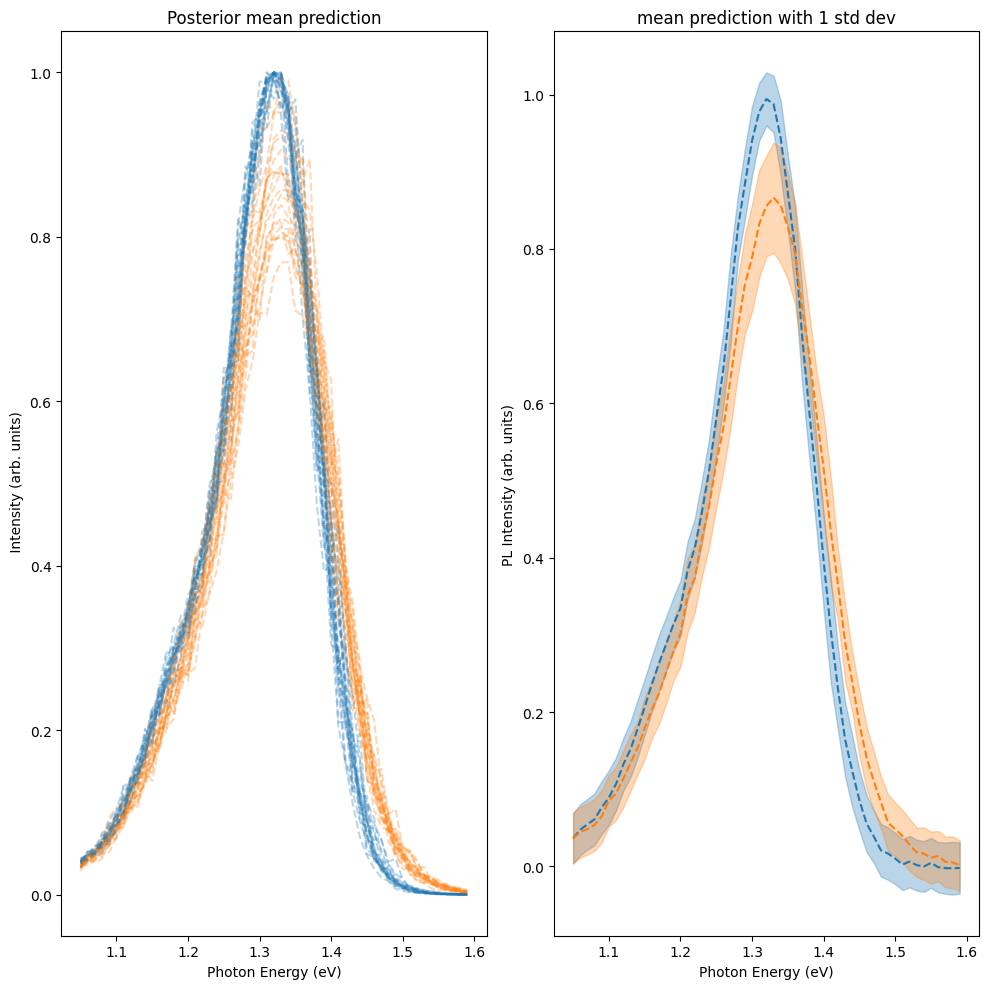

In [ ]:
from pl_temp_fit import Emcee_utils, fit_pl_utils

importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)
importlib.reload(fit_pl_utils)
importlib.reload(Emcee_utils)

Temp_std_err = model_config_save["Temp_std_err"]
hws_std_err = model_config_save["hws_std_err"]
relative_intensity_std_error_pl = model_config_save[
    "relative_intensity_std_error_pl"
]
sigma = model_config_save["sigma"]
save_folder = model_config_save["save_folder"]
fixed_parameters_dict = model_config_save["fixed_parameters_dict"]
params_to_fit_init = model_config_save["params_to_fit_init"]
min_bounds = model_config_save["min_bounds"]
max_bounds = model_config_save["max_bounds"]
csv_name = model_config_save["csv_name_pl"]
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)

co_var_mat_pl, variance_pl = covariance_utils.plot_generated_data_pl(
    save_folder,
    model_config,
    savefig=True,
    fixed_parameters_dict=fixed_parameters_dict,
    params_to_fit=true_parameters,
)

fit_pl_utils.run_sampler_parallel(
    save_folder,
    Exp_data,
    co_var_mat_pl,
    params_to_fit_init,
    fixed_parameters_dict,
    min_bounds,
    max_bounds,
    model_config,
    nsteps=10000,
    coeff_spread=1,
    num_coords=32,
    restart_sampling=True,
    num_processes=32,
)

shape of mean value plot is (55, 2)
no sampler found


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]

single process took 7.1 seconds


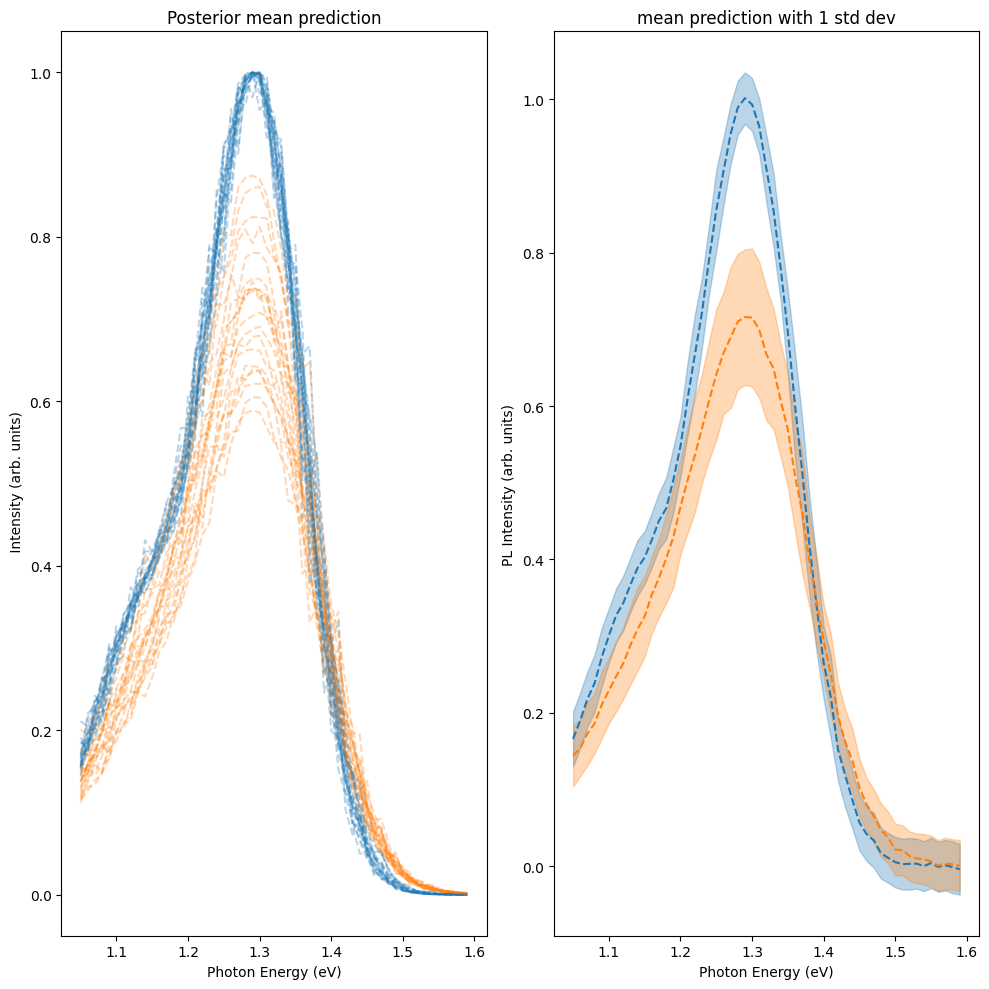

In [ ]:
from pl_temp_fit import Emcee_utils, fit_pl_utils

importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)
importlib.reload(fit_pl_utils)
importlib.reload(Emcee_utils)


Temp_std_err = model_config_save["Temp_std_err"]
hws_std_err = model_config_save["hws_std_err"]
relative_intensity_std_error_pl = model_config_save[
    "relative_intensity_std_error_pl"
]
sigma = model_config_save["sigma"]
save_folder = model_config_save["save_folder"]
fixed_parameters_dict = model_config_save["fixed_parameters_dict"]
params_to_fit_init = model_config_save["params_to_fit_init"]
min_bounds = model_config_save["min_bounds"]
max_bounds = model_config_save["max_bounds"]
csv_name = model_config_save["csv_name_pl"]
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)

co_var_mat_pl, variance_pl = covariance_utils.plot_generated_data_pl(
    save_folder,
    model_config,
    savefig=True,
    fixed_parameters_dict=fixed_parameters_dict,
    params_to_fit=true_parameters,
)
filename = model_config_save["save_folder"] + "/sampler_single.h5"
if os.path.exists(filename):
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    distribution = reader.get_chain(discard=0, flat=True)
    true_parameters = fit_pl_utils.get_param_dict(
        model_config_save["params_to_fit_init"], distribution[-1]
    )
else:
    true_parameters = model_config_save["params_to_fit_init"]
    print("no sampler found")
save_folder = model_config_save["save_folder"] + "/single_core"
os.makedirs(save_folder, exist_ok=True)
fit_pl_utils.run_sampler_single(
    save_folder,
    Exp_data,
    co_var_mat_pl,
    params_to_fit_init,
    fixed_parameters_dict,
    min_bounds,
    max_bounds,
    model_config,
    nsteps=5,
    coeff_spread=0.1,
    num_coords=32,
    restart_sampling=False,
    # num_processes=32,
)

### run sampling in the HPC


In [ ]:
model_config_id = test_id
csv_name = model_config_save["csv_name_pl"]
results_name = csv_name.replace(".csv", "").split("/")[-1]
sh_name = f"Run_EMCEE_{results_name}.sh"
script = (
    "#!/bin/bash \n"
    + "#PBS -l walltime=07:59:01 \n"
    + "#PBS -l select=1:ncpus=32:mem=80gb:avx=true \n"
    + " \n"
    + "cd /rds/general/user/hy2120/home/pl_temp_fit/ \n"
    + "module load anaconda3/personal \n"
    + "source activate pl_temp_fit     \n"
    + f"python src/pl_temp_fit/scripts/run_pl_sampling.py --model_config_id {model_config_id} \n"
)  # ${'PBS_ARRAY_INDEX'}#f"#PBS -J 1-{16} \n"+\
print(script)
with open(f"HPC_bash_script/{sh_name}", "wb") as f:
    f.write(bytes(script, "utf-8"))
script = (
    f"qsub  -e ./cache -o ./cache HPC_bash_script/{sh_name}"  # submit to HPC
)
os.system(script)

#!/bin/bash 
#PBS -l walltime=07:59:01 
#PBS -l select=1:ncpus=32:mem=80gb:avx=true 
 
cd /rds/general/user/hy2120/home/pl_temp_fit/ 
module load anaconda3/personal 
source activate pl_temp_fit     
python src/pl_temp_fit/scripts/run_pl_sampling.py --model_config_id 7fc02986-c5b0-4134-9b12-e009e90280e3 

26576.pbs


0

to run the scipt using the hpc you can just submit the job above

if you want ot run the job on the terminal you can run the script from the folder of pl_temp_fit using  for example

        python src/pl_temp_fit/scripts/run_pl_sampling.py --model_config_id e7ed53f3-f1ef-46c2-9b98-35b366e9f04d 

where e7ed53f3-f1ef-46c2-9b98-35b366e9f04d  correspond to your model config id